In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color='blue')
    else:
        plt.plot(train_s.index, train_s, label='Train', color='blue')
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=10),   train_s.index.union(indices)[::10], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse


In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_tenerife = datos[datos['isla'] == 'TENERIFE']
datos_tenerife = datos_tenerife.set_index('fecha')

variables_covid = ['pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']
variables_atm = ['tmin', 'tmed', 'presMax']
variables = ['pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10 # días a agrupar 

datos_tenerife_uni = datos_tenerife[objetivo]
datos_tenerife_uni_arr = np.array(datos_tenerife_uni).reshape(-1, 1)

datos_Tenerife_mult_covid = datos_tenerife[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
datos_Tenerife_mult_atm = datos_tenerife[[objetivo, 'tmin', 'tmed', 'presMax']]
datos_Tenerife_mult_total = datos_tenerife[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']]

# Red Neuronal Recurrente univariable

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_tenerife_uni_scaled = scaler.fit_transform(datos_tenerife_uni_arr)

In [5]:
n_train = len(datos_tenerife_uni_scaled) - dias_prediccion


train = datos_tenerife_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_tenerife_uni_scaled[n_train - dias_prediccion:len(datos_tenerife_uni_scaled), :]

In [6]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [7]:
model = Sequential()
model.add(LSTM(14, 
               activation='relu',
               return_sequences=True, 
               input_shape=(X_train.shape[1], 1))) 
model.add(LSTM(50, 
               activation='relu',
               return_sequences=True)) 
model.add(LSTM(25, 
               activation='relu',
               return_sequences=False)) 
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)


Epoch 1/50
7/7 [==============================] - 3s 74ms/step - loss: 0.0264 - val_loss: 0.0115
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0225 - val_loss: 0.0063
Epoch 3/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0206 - val_loss: 0.0039
Epoch 4/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0201 - val_loss: 0.0038
Epoch 5/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0187 - val_loss: 0.0045
Epoch 6/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0171 - val_loss: 0.0037
Epoch 7/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0144 - val_loss: 0.0040
Epoch 8/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0040
Epoch 9/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0087 - val_loss: 0.0060
Epoch 10/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 11/50
7/7 [============

In [8]:
test_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 330ms/step


In [9]:
y_pred

array([[847.31213],
       [814.0497 ],
       [767.42914],
       [730.80963],
       [670.4704 ],
       [621.0288 ],
       [586.52106],
       [594.64154],
       [610.1981 ],
       [609.8333 ]], dtype=float32)

In [10]:
y_test

array([[269.],
       [193.],
       [636.],
       [760.],
       [716.],
       [607.],
       [636.],
       [266.],
       [163.],
       [319.]])

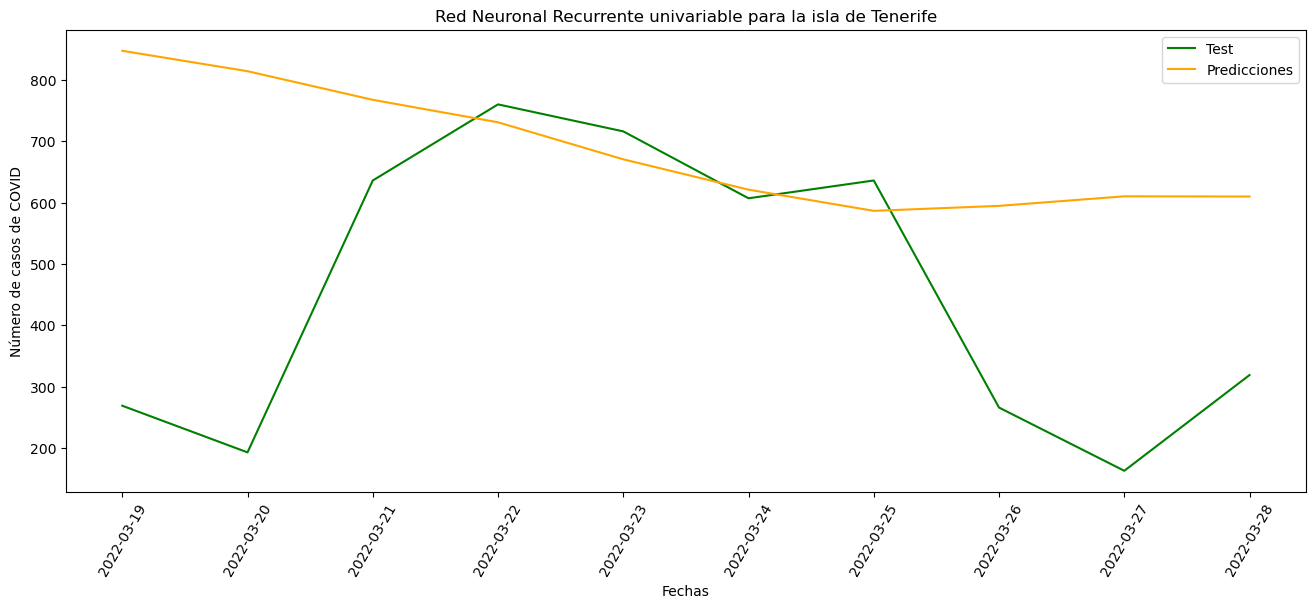

In [11]:
isla = 'Tenerife'
fechas = datos_tenerife.tail(10).index
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

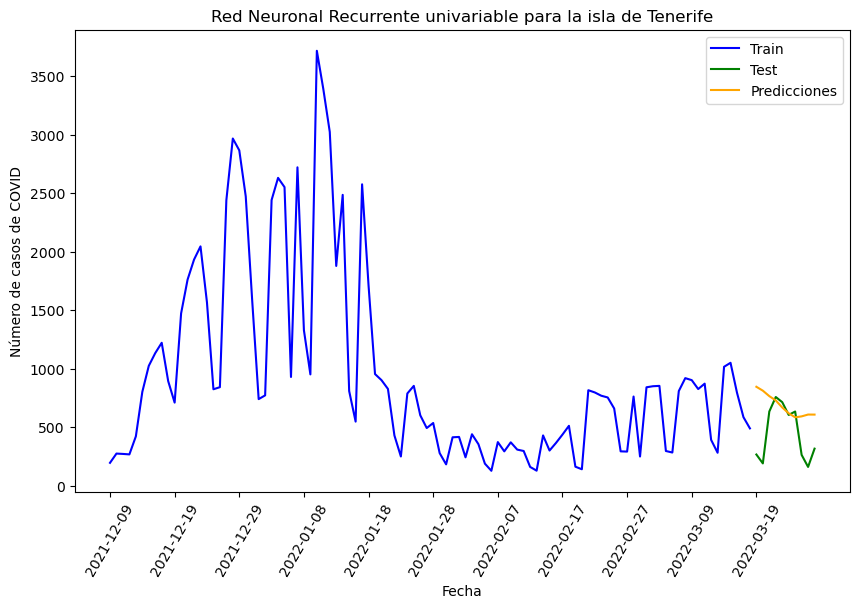

In [12]:
datos_train = datos_tenerife_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [13]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 113556.66830136851
Error absoluto medio (MAE) del modelo: 253.5691650390625
Raíz del error cuadrático medio (RMSE) del modelo: 336.9817032145344


# Red Neuronal Recurrente multivariable con variables de pandemia

In [14]:
datos_Tenerife_mult_covid = datos_tenerife[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled = scaler.fit_transform(datos_Tenerife_mult_covid)

In [15]:
# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_covid[objetivo]).reshape(-1, 1))

In [16]:
n_train = len(datos_Tenerife_mult_covid_scaled) - dias_prediccion


train = datos_Tenerife_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_covid_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_covid_scaled), :]

In [17]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [18]:
model = Sequential()
model.add(LSTM(X_train.shape[1] * X_train.shape[2], 
               activation='relu',
               return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(LSTM(60, 
               activation='relu',
               return_sequences=True)) 
model.add(LSTM(25, 
               activation='relu',
               return_sequences=False)) 
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)


Epoch 1/50
7/7 [==============================] - 3s 70ms/step - loss: 0.0266 - val_loss: 0.0088
Epoch 2/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0213 - val_loss: 0.0042
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0194 - val_loss: 0.0044
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0168 - val_loss: 0.0060
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0135 - val_loss: 0.0076
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0104 - val_loss: 0.0090
Epoch 7/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0089 - val_loss: 0.0049
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0078 - val_loss: 0.0041
Epoch 9/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0075 - val_loss: 0.0042
Epoch 10/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0070 - val_loss: 0.0039
Epoch 11/50
7/7 [============

In [19]:
test_pred = model.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 300ms/step


In [20]:
y_pred

array([[ 682.7887 ],
       [ 696.97034],
       [ 851.0047 ],
       [1042.1337 ],
       [ 801.51196],
       [ 551.7868 ],
       [ 530.6775 ],
       [ 482.9613 ],
       [ 627.0555 ],
       [ 991.4241 ]], dtype=float32)

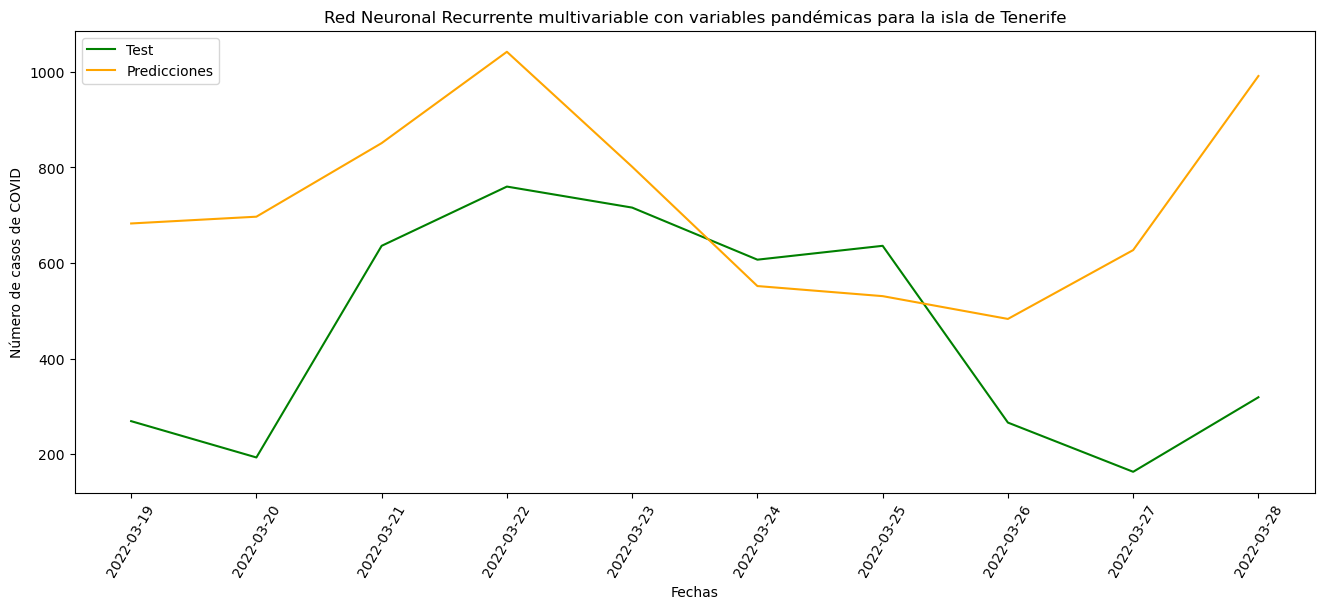

In [21]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

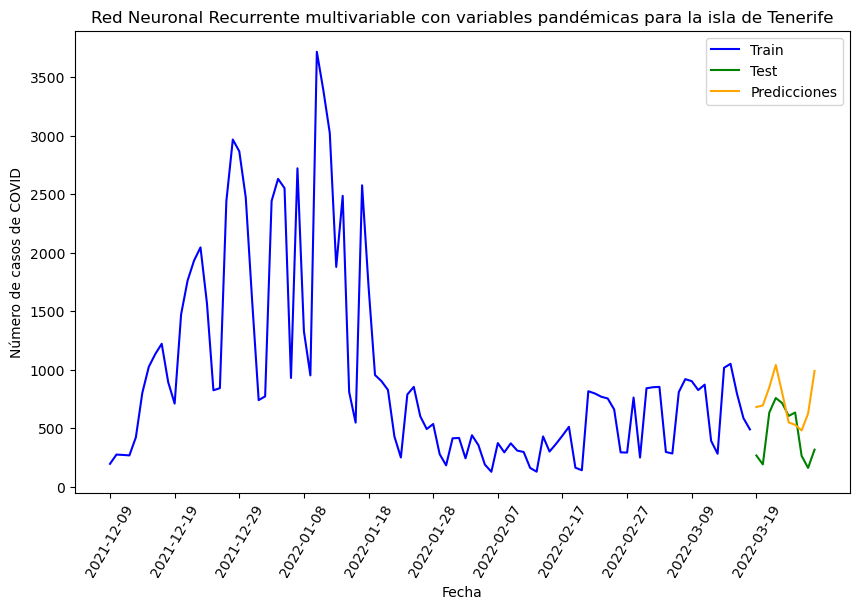

In [22]:
datos_train = datos_Tenerife_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [23]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 128706.10661402158
Error absoluto medio (MAE) del modelo: 301.4385925292969
Raíz del error cuadrático medio (RMSE) del modelo: 358.7563332040587


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled = scaler.fit_transform(datos_Tenerife_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_atm[objetivo]).reshape(-1, 1))

In [25]:
n_train = len(datos_Tenerife_mult_atm_scaled) - dias_prediccion


train = datos_Tenerife_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_atm_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_atm_scaled), :]

In [26]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [27]:
model = Sequential()
model.add(LSTM(X_train.shape[1] * X_train.shape[2], 
               activation='relu',
               return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(LSTM(60, 
               activation='relu',
               return_sequences=True)) 
model.add(LSTM(25, 
               activation='relu',
               return_sequences=False)) 
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
7/7 [==============================] - 3s 70ms/step - loss: 0.0263 - val_loss: 0.0073
Epoch 2/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0212 - val_loss: 0.0040
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0207 - val_loss: 0.0045
Epoch 4/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0191 - val_loss: 0.0052
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0172 - val_loss: 0.0035
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0130 - val_loss: 0.0039
Epoch 7/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0087 - val_loss: 0.0068
Epoch 8/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0090 - val_loss: 0.0052
Epoch 9/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0080 - val_loss: 0.0044
Epoch 10/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0079 - val_loss: 0.0053
Epoch 11/50
7/7 [============

In [28]:
test_pred = model.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 296ms/step


In [29]:
y_pred

array([[608.7422 ],
       [538.60956],
       [510.19937],
       [541.0082 ],
       [459.12286],
       [318.03107],
       [365.85477],
       [428.3332 ],
       [444.239  ],
       [458.30606]], dtype=float32)

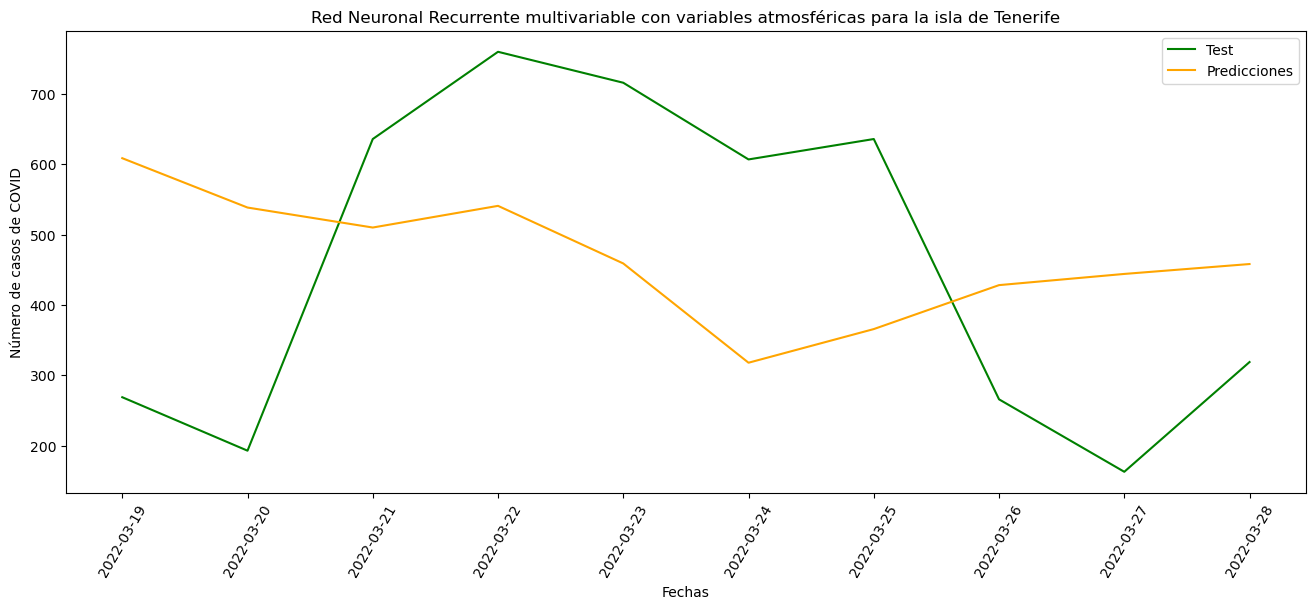

In [30]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

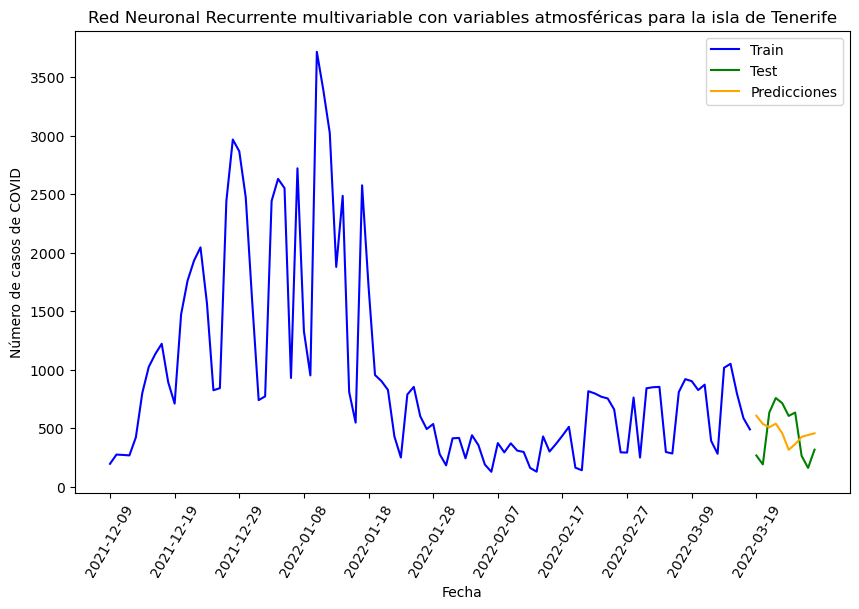

In [31]:
datos_train = datos_Tenerife_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [32]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 64597.49172563432
Error absoluto medio (MAE) del modelo: 242.90137634277343
Raíz del error cuadrático medio (RMSE) del modelo: 254.16036615812922


# Red Neuronal Recurrente multivariable con todas las variables

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled = scaler.fit_transform(datos_Tenerife_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_total[objetivo]).reshape(-1, 1))

In [34]:
n_train = len(datos_Tenerife_mult_total_scaled) - dias_prediccion


train = datos_Tenerife_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_total_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_total_scaled), :]

In [35]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [36]:
model = Sequential()
model.add(LSTM(X_train.shape[1] * X_train.shape[2], 
               activation='relu',
               return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(LSTM(60, 
               activation='relu',
               return_sequences=True)) 
model.add(LSTM(25, 
               activation='relu',
               return_sequences=False)) 
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
7/7 [==============================] - 3s 70ms/step - loss: 0.0256 - val_loss: 0.0064
Epoch 2/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0042
Epoch 3/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0164 - val_loss: 0.0049
Epoch 4/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0127 - val_loss: 0.0049
Epoch 5/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0089 - val_loss: 0.0035
Epoch 6/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0090 - val_loss: 0.0057
Epoch 7/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0077 - val_loss: 0.0040
Epoch 8/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0084 - val_loss: 0.0058
Epoch 9/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0042
Epoch 10/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 11/50
7/7 [============

In [37]:
test_pred = model.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 297ms/step


In [38]:
y_pred

array([[498.2178 ],
       [459.6439 ],
       [487.79703],
       [592.1974 ],
       [480.7643 ],
       [306.00876],
       [341.95126],
       [338.01984],
       [342.40445],
       [464.89047]], dtype=float32)

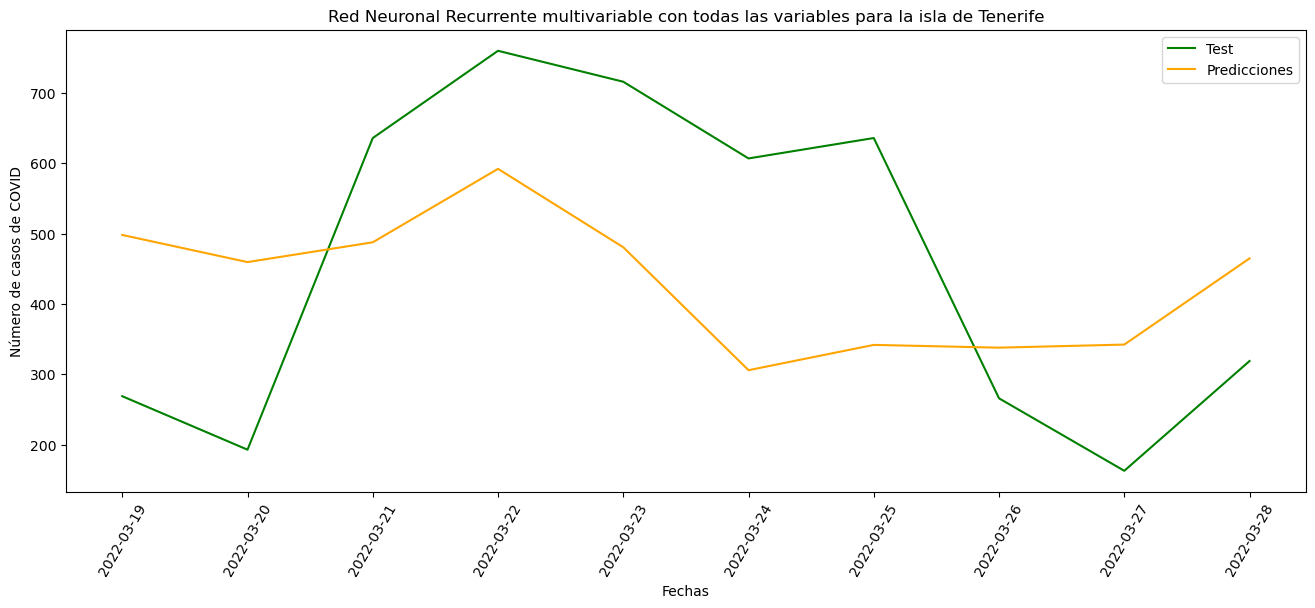

In [39]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

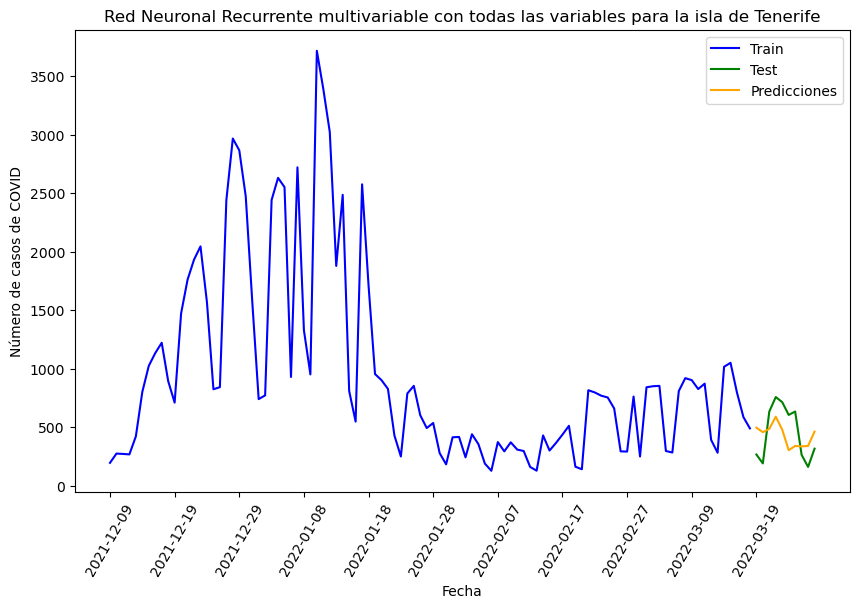

In [40]:
datos_train = datos_Tenerife_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [41]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 46481.4662393149
Error absoluto medio (MAE) del modelo: 203.94577026367188
Raíz del error cuadrático medio (RMSE) del modelo: 215.59560811694402
